# Kubeflow Pipeline Development
![](./images/feature-engineering.png)

In [1]:
import kfp
from kfp import components
from kfp.components import func_to_container_op
import kfp.dsl as dsl
import kfp.components as comp

# Provision Storage
We need shared storage. We use [NetApp's Trident](https://github.com/NetApp/trident) to provide data persistence across our pipeline.

In [9]:
def create_agent_data_vol(namespace,model_name,storage_class):
    return dsl.VolumeOp(
        name='smap_training_vol',
        resource_name=str(model_name) + '-pvc',
        size='10Gi',
        modes=['ReadWriteMany'],
        storage_class=storage_class
    )

In [2]:
s3_endpoint='https://minio-kubeflow.apps.kubeflow.openshift.red8.cloud'
access_key='minio'
secret_access_key='minio123'
bucket_name='mlpipeline'
region='us-east-1'

In [4]:
import s3fs
import pyarrow.parquet as pq

s3 = s3fs.S3FileSystem(
    client_kwargs=dict(
        endpoint_url=s3_endpoint
    ),
    key=access_key,
    secret=secret_access_key
    )
pandas_dataframe = pq.ParquetDataset('s3://mlpipeline/data/training.parquet', filesystem=s3).read_pandas().to_pandas()

/home/jovyan/.local/lib/python3.6/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/home/jovyan/.local/lib/python3.6/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/home/jovyan/.local/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


# Load our data
Training data consists of labels and short documents.

Labels will be either `legitimate` or `spam`

In [5]:
import pandas as pd
import warnings; warnings.simplefilter("ignore")
data = pd.read_parquet("data/training.parquet")

From [Wikipedia](https://en.wikipedia.org/wiki/Feature_engineering#:~:text=Feature%20engineering%20is%20the%20process,as%20applied%20machine%20learning%20itself):

> Feature engineering is the process of using domain knowledge to extract *features* from raw data.


We can use these features in machine learning models, to make predictions. We're going to use an approach called TF-IDF in this notebook.

This algoritm essentially takes a document and assigns it a value based on word frequency. 

In [6]:
from sklearn.feature_extraction.text import HashingVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
import pickle, os

vect = HashingVectorizer(norm=None, token_pattern='(?u)\\b[A-Za-z]\\w+\\b', n_features=1024, alternate_sign = False)

tfidf = TfidfTransformer()

feat_pipeline = Pipeline([
    ('vect',vect),
    ('tfidf',tfidf)
])

from mlworkflows import util
util.serialize_to(feat_pipeline, "feature_pipeline.sav")

In [11]:
feature_vecs = feat_pipeline.fit_transform(data["text"]).toarray()
labeled_vecs = pd.concat([data.reset_index()[["index", "label"]],
                                pd.DataFrame(feature_vecs)], axis=1)
labeled_vecs.columns = labeled_vecs.columns.astype(str)
with s3.open('mlpipeline/data/features.parquet','wb') as f:
    labeled_vecs.to_parquet(f)

# Visualize our results

In [12]:
import sklearn.decomposition

DIMENSIONS = 2

pca2 = sklearn.decomposition.TruncatedSVD(DIMENSIONS)

pca_a = pca2.fit_transform(labeled_vecs[labeled_vecs.columns[2:]].values)

Let's plot the vector summary of each document.

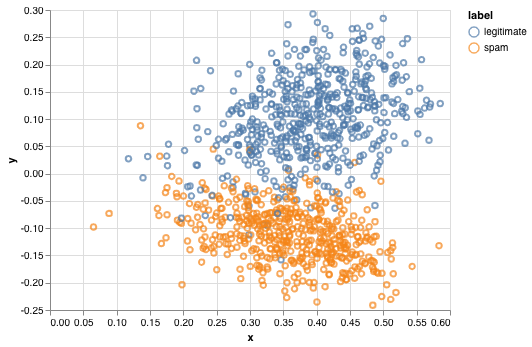

In [13]:
pca_df = pd.DataFrame(pca_a, columns=["x", "y"])
pca_df.sample(10)

plot_data = pd.concat([data.reset_index(), pca_df], axis=1)

import altair as alt
alt.renderers.enable('notebook')

alt.Chart(plot_data.sample(1000)).encode(x="x", y="y", color="label").mark_point().interactive()

The plot above shows 